In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
from matplotlib import pyplot as plt
import multigrate as mtg

# Load data

In [2]:
adata = sc.read('multigrate/data/10x-cite/10x-cite.h5ad')
adata

AnnData object with n_obs × n_vars = 10849 × 15792
    obs: 'n_genes', 'percent_mito', 'n_counts', 'batch', 'labels'
    var: 'encode', 'n_cells-0', 'highly_variable-0', 'hvg_encode-0', 'n_cells-1', 'highly_variable-1', 'hvg_encode-1'
    obsm: 'protein_expression'

In [3]:
adata.obs.batch = adata.obs.batch.astype('category')
ref = adata[adata.obs.batch == 0]
ref

/home/icb/anastasia.litinetskaya/miniconda3/envs/multigrate/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


View of AnnData object with n_obs × n_vars = 6855 × 15792
    obs: 'n_genes', 'percent_mito', 'n_counts', 'batch', 'labels'
    var: 'encode', 'n_cells-0', 'highly_variable-0', 'hvg_encode-0', 'n_cells-1', 'highly_variable-1', 'hvg_encode-1'
    obsm: 'protein_expression'

In [4]:
cite = sc.AnnData(ref.obsm['protein_expression'])

In [5]:
query = adata[adata.obs.batch == 1].copy()
query

AnnData object with n_obs × n_vars = 3994 × 15792
    obs: 'n_genes', 'percent_mito', 'n_counts', 'batch', 'labels'
    var: 'encode', 'n_cells-0', 'highly_variable-0', 'hvg_encode-0', 'n_cells-1', 'highly_variable-1', 'hvg_encode-1'
    obsm: 'protein_expression'

In [6]:
query.obs['cell_type'] = query.obs['labels']
query

AnnData object with n_obs × n_vars = 3994 × 15792
    obs: 'n_genes', 'percent_mito', 'n_counts', 'batch', 'labels', 'cell_type'
    var: 'encode', 'n_cells-0', 'highly_variable-0', 'hvg_encode-0', 'n_cells-1', 'highly_variable-1', 'hvg_encode-1'
    obsm: 'protein_expression'

In [7]:
query_protein = sc.AnnData(query.obsm['protein_expression'])

## Normalize ADT counts
Taken from https://github.com/theislab/scanpy/issues/1208, also discussed in https://github.com/theislab/scanpy/pull/1117.

In [8]:
def clr_normalize_each_cell(adata, inplace=True):
    """Normalize count vector for each cell, i.e. for each row of .X"""

    import numpy as np
    import scipy

    def seurat_clr(x):
        # TODO: support sparseness
        s = np.sum(np.log1p(x[x > 0]))
        exp = np.exp(s / len(x))
        return np.log1p(x / exp)

    if not inplace:
        adata = adata.copy()

    # apply to dense or sparse matrix, along axis. returns dense matrix
    adata.X = np.apply_along_axis(
        seurat_clr, 1, (adata.X.A if scipy.sparse.issparse(adata.X) else adata.X)
    )
    return adata

In [9]:
cite = clr_normalize_each_cell(cite)

In [10]:
query_protein = clr_normalize_each_cell(query_protein)

In [11]:
query_protein.obsm['protein'] = query_protein.X

In [12]:
ref.obs['cell_type'] = ref.obs['labels']

Trying to set attribute `.obs` of view, copying.


In [13]:
cite.obs = ref.obs
cite

AnnData object with n_obs × n_vars = 6855 × 14
    obs: 'n_genes', 'percent_mito', 'n_counts', 'batch', 'labels', 'cell_type'

# Configure and train the model

In [14]:
model = mtg.models.MultiVAE(
    adatas=[[ref], [cite]],
    names=[['RNA'], ['ADT']],
    pair_groups=[[0], [0]],
    condition=True,
    z_dim=14,
    h_dim=14,
    hiddens=[[], []],
    output_activations=['linear', 'relu'],
    losses=['nb', 'mse'],
    shared_hiddens=[],
    adver_hiddens=[],
    normalization='batch',
    recon_coef=1,
    kl_coef=1e-5,
    integ_coef=1e-2, # don't have here as 1 dataset
    cycle_coef=0,
    adversarial=False,
    dropout=0.2,
)

In [15]:
model.train(
    n_iters=5000,
    batch_size=64,
    lr=3e-4,
    val_split=0.1,
    adv_iters=0,
    kl_anneal_iters=2000,
    validate_every=500,
    verbose=1
)

 |████████████████████| 100.0% iter=5000/5000, time=39.74(s), loss=0.6260, recon=0.6255, kl=59.3445, integ=0.0000, cycle=0.0000, val_loss=0.4602, val_recon=0.4597, val_kl=51.8539, val_integ=0.0000, val_cycle=0.0000

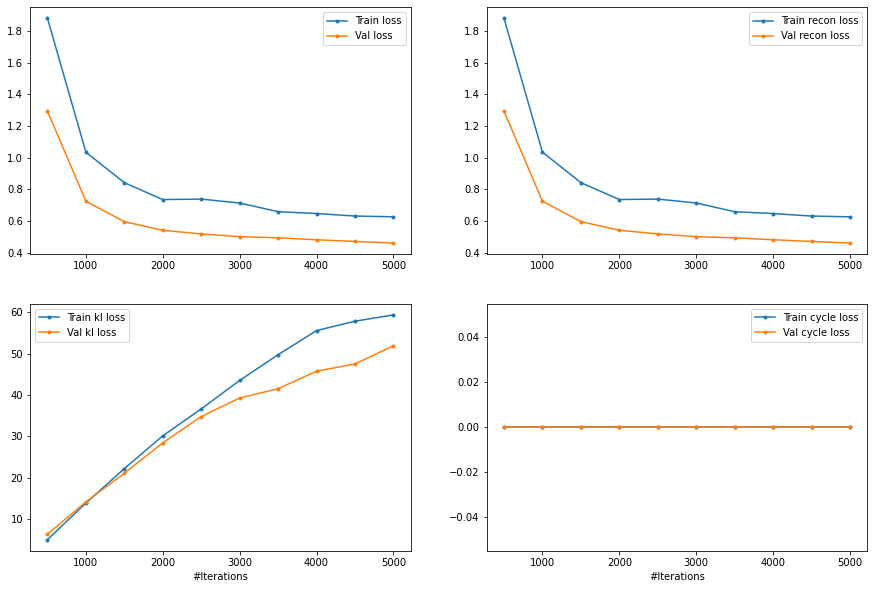

In [16]:
plt.figure(figsize=(15, 10));
plt.subplot(221);
plt.plot(model.history['iteration'], model.history['train_loss'], '.-', label='Train loss');
plt.plot(model.history['iteration'], model.history['val_loss'], '.-', label='Val loss');
plt.legend();

plt.subplot(222);
plt.plot(model.history['iteration'], model.history['train_recon'], '.-', label='Train recon loss');
plt.plot(model.history['iteration'], model.history['val_recon'], '.-', label='Val recon loss');
plt.legend();

plt.subplot(223);
plt.plot(model.history['iteration'], model.history['train_kl'], '.-', label='Train kl loss');
plt.plot(model.history['iteration'], model.history['val_kl'], '.-', label='Val kl loss');
plt.xlabel('#Iterations');
plt.legend();

plt.subplot(224);
plt.plot(model.history['iteration'], model.history['train_cycle'], '.-', label='Train cycle loss');
plt.plot(model.history['iteration'], model.history['val_cycle'], '.-', label='Val cycle loss');
plt.xlabel('#Iterations');
plt.legend();


In [17]:
z = model.impute([[query],[]],
        names=[['query-RNA'], []],
        pair_groups = [[1], []],
        target_modality = 1,
        batch_labels = [[0], []],
        batch_size = 64)
z

/home/icb/anastasia.litinetskaya/miniconda3/envs/multigrate/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


AnnData object with n_obs × n_vars = 3994 × 14
    obs: 'modality', 'barcode', 'cell_type', 'batch'

In [18]:
z.obsm['predicted_protein'] = z.X
z

AnnData object with n_obs × n_vars = 3994 × 14
    obs: 'modality', 'barcode', 'cell_type', 'batch'
    obsm: 'predicted_protein'

In [19]:
from scipy.stats import pearsonr

protein_corrs = []
for i, protein in enumerate(query_protein.var_names):
    protein = protein[:-10]
    protein_corrs.append(protein + ': Corr=' + str(np.round(pearsonr(z.obsm['predicted_protein'][:, i], query_protein.obsm['protein'][:, i])[0], 3)))
    
protein_corrs

['CD3: Corr=0.763',
 'CD4: Corr=0.12',
 'CD8a: Corr=0.228',
 'CD14: Corr=0.192',
 'CD15: Corr=0.124',
 'CD16: Corr=-0.22',
 'CD56: Corr=-0.297',
 'CD19: Corr=-0.039',
 'CD25: Corr=-0.215',
 'CD45RA: Corr=0.017',
 'CD45RO: Corr=-0.258',
 'PD-1: Corr=0.195',
 'TIGIT: Corr=-0.156',
 'CD127: Corr=0.669']